# Performance Test for Iterative Solvers on 2D Laplace equation

The goal of this notebook is to compare the performance of different iterative solvers for solving the 2D Laplace equation on the domain $(0,1)^2$

$$ 
    - \Delta u(x) = f(x) \text{ for } x \in \Omega\\
    u(x) = g(x) \text{ for } x \in \partial \Omega
$$

Here, we consider $f \equiv 0$ and $g(x_1,x_2) = 5 x_2 \sin(\pi x_1)$. We use a regular mesh with $n$ number of cells into both directions. The following cell discretizes the Laplacian using finite differences, gets the boundary and interior, and builds the boundary condition.

The discrete problem gives rise to a sparse linear system where the operator is symmetric and positive definite. It is commonly used iteratively using (preconditioned) Conjugate Gradient (PCG) method. Here, we do not use preconditioning and compare the performance of the packages 

1. [`IterativeSolvers.jl`](https://github.com/JuliaLang/IterativeSolvers.jl)
2. [`Krylov`](https://github.com/JuliaOptimizers/Krylov.jl)
3. [`KrylovMethods.jl`](https://github.com/lruthotto/KrylovMethods.jl). 

In this example, we are timing the performance of sparse matrix vector products as well as some level 1 BLAS routines. To accelerate the sparse matrix vector products we also consider here the OpenMP+Fortran based code provided by [`ParSpMatVec.jl`](https://github.com/JuliaInv/ParSpMatVec.jl).

In [162]:
"""
ibc,iin = getBoundaryIndices(n::Int)

returns indices of boundary and interior nodes of regular mesh with n^2 cells.
"""
function getBoundaryIndices(n::Int)
    ids = reshape(collect(1:(n+1)^2),n+1,n+1)
    iin = vec(ids[2:end-1,2:end-1])
    ibc = setdiff(vec(ids),vec(iin))
    return ibc,iin
end

"""
L,Lin,Lib = getLaplacian(n::Int)

returns discrete Laplacian, interior part, and boundary part, on regular mesh with n^2 cells.
"""
function getLaplacian(n::Int)
    h  = 1/n
    dx = spdiagm((-ones(n,1),ones(n,1)),0:1,n,n+1)/h
    d2x = dx'*dx
    L  = kron(I(n+1),d2x) + kron(d2x,I(n+1))
    
    # split into boundary and interior part
    ibc,iin = getBoundaryIndices(n)
    Lin = L[iin,iin]
    Lib = L[iin,ibc]
    return L,Lin,Lib
end
"""
g = getBoundaryConditions(n::Int,fctn=(x,y)->5.*y*sin(pi*x))

discretizes function on regular grid with n^2 cells and returns boundary part
"""
function getBoundaryConditions(n::Int,fctn=(x,y)->5.*y*sin(pi*x))
    x  = linspace(0,1,n+1)
    g = map(Float64,[fctn(x1,x2) for x1 in x, x2 in x]')
    ibc,iin = getBoundaryIndices(n)
    return vec(g)[ibc]
end

getBoundaryConditions (generic function with 4 methods)

## Setup Tests

In [159]:
using KrylovMethods
using IterativeSolvers
using Krylov
using ParSpMatVec
using Base.Test

Ns = 128*[1,2,3,4,5,6]  # number of grid points
nTrials = 10            # number of repititions
nthreads = 2            # number of threads used to accelerate sparse matvecs

# allocate space for results
timesKM    = zeros(length(Ns),nTrials)
timesK     = zeros(length(Ns),nTrials)
timesKMOpt = zeros(length(Ns),nTrials)
timesIS    = zeros(length(Ns),nTrials);

## Run Tests

In [161]:
for k=1:length(Ns)
    n = Ns[k]
    
    # build linear operator and boundary condition
    L,Lin,Lib = getLaplacian(n)
    ubc       = getBoundaryConditions(n)
    
    if k==1 # warmup
        resKM = KrylovMethods.cg(Lin,vec(-Lib*ubc),tol=1e-4,maxIter=2,out=-1);
        resK = Krylov.cg(Lin,vec(-Lib*ubc),rtol=1e-4,itmax=2)
        resIS = IterativeSolvers.cg(Lin,vec(-Lib*ubc),tol=1e-12,maxiter=2)
    end
    for j=1:nTrials
		tic()
        resKM = KrylovMethods.cg(Lin,vec(-Lib*ubc),tol=1e-12,maxIter=100,out=-1)
		timesKM[k,j] = toq();
        iterKM = resKM[4]
        relresKM = resKM[3]

		tic()
        xK,resK = Krylov.cg(Lin,vec(-Lib*ubc),rtol=1e-12,itmax=100)
		timesK[k,j] = toq();
iterK  = length(resK.residuals)-2
        relresK = norm(Lin*xK+vec(Lib*ubc))/norm(vec(Lib*ubc))
        @test iterK==iterKM
 		@test abs(relresK-relresKM)/relresKM < 1e-1


		tic()
		yt = zeros(size(Lin,1))
        Afun(x) = (yt[:]=0.0; ParSpMatVec.Ac_mul_B!( 1.0, Lin, x, 0.0, yt, nthreads); return yt)
		resKMOpt = KrylovMethods.cg(Afun,vec(-Lib*ubc),tol=1e-12,maxIter=100,out=-1)
		timesKMOpt[k,j] = toq();
        iterKMOpt   = resKM[4]
        relresKMOpt = resKMOpt[3]       
		@test iterKMOpt==iterKM
		@test abs(relresKMOpt-relresKM)/relresKM < 1e-1


		tic()
		resIS = IterativeSolvers.cg(Lin,vec(-Lib*ubc),tol=1e-12,maxiter=100)
		timesIS[k,j] = toq();
		iterIS =length(resIS[2].residuals)
		relresIS = norm(Lin*resIS[1]+vec(Lib*ubc))/norm(vec(Lib*ubc))
		@test iterIS==iterKM
		@test abs(relresIS-relresKM)/relresKM < 1e-2
		
    end
	
println("n=$n, KM.jl: $(mean(timesKM[k,:])) K.jl:$(mean(timesK[k,:]))  KM.jl+ParSpMat:$(mean(timesKMOpt[k,:])) IterativeSolvers: $(mean(timesIS[k,:]))")
end


n=128, KM.jl: 0.0174430161 K.jl:0.021050261999999997  KM.jl+ParSpMat:0.014071255700000002 IterativeSolvers: 0.0427048753
n=256, KM.jl: 0.0803822188 K.jl:0.10896088410000002  KM.jl+ParSpMat:0.054290362700000004 IterativeSolvers: 0.2333258811
n=384, KM.jl: 0.20394096379999999 K.jl:0.25968237930000004  KM.jl+ParSpMat:0.1342229413 IterativeSolvers: 0.45996755
n=512, KM.jl: 0.4013892215 K.jl:0.5037385965  KM.jl+ParSpMat:0.24051531880000004 IterativeSolvers: 0.7948175996
n=640, KM.jl: 0.7020725942 K.jl:0.834604787  KM.jl+ParSpMat:0.41165858119999993 IterativeSolvers: 1.4536032222
n=768, KM.jl: 0.9711422812 K.jl:1.14933204  KM.jl+ParSpMat:0.6137281547000001 IterativeSolvers: 2.2194238866


## Plot Results

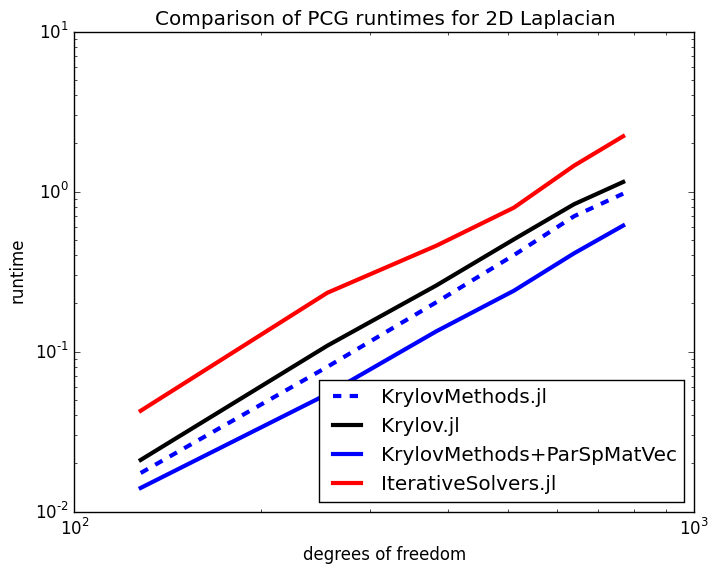

PyObject <matplotlib.legend.Legend object at 0x31f2a2150>

In [163]:
loglog(Ns,mean(timesKM,2),"--b",linewidth=3)
hold(true)
loglog(Ns,mean(timesK,2),"-k",linewidth=3)
loglog(Ns,mean(timesKMOpt,2),"-b",linewidth=3)
loglog(Ns,mean(timesIS,2),"-r",linewidth=3)
xlabel("degrees of freedom")
ylabel("runtime")
title("Comparison of PCG runtimes for 2D Laplacian")
legend(("KrylovMethods.jl","Krylov.jl","KrylovMethods+ParSpMatVec","IterativeSolvers.jl"),loc=4)

In [171]:

println("mean runtime (IterativeSolvers.cg)\t\t\t$(mean(timesIS[end,:]))")
println("mean runtime (Krylov.cg)\t\t\t\t$(mean(timesK[end,:]))")
println("mean runtime (KrylovMethods.cg)\t\t\t\t$(mean(timesKM[end,:]))")
println("mean runtime (KrylovMethods.cg + ParSpMatVec.jl)\t$(mean(timesKMOpt[end,:]))")


mean runtime (IterativeSolvers.cg)			2.2194238866
mean runtime (Krylov.cg)				1.14933204
mean runtime (KrylovMethods.cg)				0.9711422812
mean runtime (KrylovMethods.cg + ParSpMatVec.jl)	0.6137281547000001
